<b>Universidad Galileo</b><br/>
<b>Maestría de Ciencia de Datos</b><br/>
<b>Statistical Learning I</b><br/>
<b>Jose Godoy</b><br/>
<b>Carnet 22000570</b><br/>
<b>30 de julio 2022</b><br/>

# 1. Cargando librerías

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score

# 2. Funciones

Estimación normal

In [2]:
def estimateGaussian(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.cov(dataset.T)
    return mu, sigma

Normal multivariable

In [3]:
def multivariateGaussian(dataset, mu, sigma):
    p = multivariate_normal(mean=mu, cov=sigma)
    return p.pdf(dataset)

Selección de límite

In [4]:
def selectThresholdByCV(probs, gt):
    best_epsilon = 0
    best_f1 = 0
    f = 0
    stepsize = (max(probs) - min(probs)) / 1000;
    epsilons = np.arange(min(probs), max(probs), stepsize)
    for epsilon in np.nditer(epsilons):
        predictions = (probs < epsilon)
        f = f1_score(gt, predictions, average = "binary")
        if f > best_f1:
            best_f1 = f
            best_epsilon = epsilon
    return best_f1, best_epsilon

# 3. Carga de datos

In [5]:
xls = pd.ExcelFile('estaturas.xlsx')
normales = pd.read_excel(xls, 'normales')
valtest_normales = pd.read_excel(xls, 'valtest(normales)')
valtest_anomalias = pd.read_excel(xls, 'valtest(anomalias)')

Renombrando columnas

In [6]:
normales = pd.DataFrame({"altura": normales.iloc[:,0], "edad": normales.iloc[:,1]})
valtest_normales = pd.DataFrame({"altura": valtest_normales.iloc[:,0], "edad": valtest_normales.iloc[:,1]})
valtest_anomalias = pd.DataFrame({"altura": valtest_anomalias.iloc[:,0], "edad": valtest_anomalias.iloc[:,1]})

Estadísticos

In [7]:
altura_mean = normales.altura.mean(axis=0)
altura_std = normales.altura.std(axis=0)
edad_mean = normales.edad.mean(axis=0)
edad_std = normales.edad.std(axis=0)

Normalización

In [8]:
normales_n = normales.copy()
normales_n.altura = (normales.altura-altura_mean)/altura_std
normales_n.edad = (normales.edad-edad_mean)/edad_std

valtest_normales_n = valtest_normales.copy()
valtest_normales_n.altura = (valtest_normales.altura-altura_mean)/altura_std
valtest_normales_n.edad = (valtest_normales.edad-edad_mean)/edad_std

valtest_anomalias_n = valtest_anomalias.copy()
valtest_anomalias_n.altura = (valtest_anomalias.altura-altura_mean)/altura_std
valtest_anomalias_n.edad = (valtest_anomalias.edad-edad_mean)/edad_std

# 4. Entrenamiento

In [9]:
mu, sigma = estimateGaussian(normales_n)
p = multivariateGaussian(normales_n, mu, sigma)

# 5. Creando set de validación y pruebas

Validación

In [10]:
# Y = 0
validacion_n_0 = valtest_normales_n[0:int(np.floor(len(valtest_normales_n)/2))]
validacion_0 = valtest_normales[0:int(np.floor(len(valtest_normales_n)/2))]
# Y = 1
validacion_n_1 = valtest_anomalias_n[0:int(np.floor(len(valtest_anomalias_n)/2))]
validacion_1 = valtest_anomalias[0:int(np.floor(len(valtest_anomalias_n)/2))]
# Uniendo
validacion_n = pd.concat([validacion_n_0, validacion_n_1])
validacion = pd.concat([validacion_0, validacion_1])

Pruebas

In [11]:
# Y = 0
pruebas_n_0 = valtest_normales_n[int(np.floor(len(valtest_normales_n)/2)):len(valtest_normales_n)]
pruebas_0 = valtest_normales[int(np.floor(len(valtest_normales_n)/2)):len(valtest_normales_n)]
# Y = 1
pruebas_n_1 = valtest_anomalias_n[int(np.floor(len(valtest_anomalias_n)/2)):len(valtest_anomalias_n)]
pruebas_1 = valtest_anomalias[int(np.floor(len(valtest_anomalias_n)/2)):len(valtest_anomalias_n)]
# Uniendo
pruebas_n = pd.concat([pruebas_n_0, pruebas_n_1])
pruebas = pd.concat([pruebas_0, pruebas_1])

# 6. Validación de datos

In [12]:
p_cv = multivariateGaussian(validacion_n, mu, sigma)
f = np.arange(start=0, stop=len(validacion_n))<int(np.floor(len(valtest_normales_n)/2))
fscore, ep = selectThresholdByCV(p_cv, f)

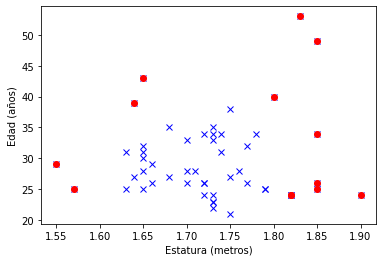

In [13]:
outliers = np.asarray(np.where(p < ep))[0]
plt.figure()
plt.xlabel("Estatura (metros)")
plt.ylabel("Edad (años)")
plt.plot(normales.iloc[:,0], normales.iloc[:,1], "bx")
plt.plot(normales.iloc[outliers,0], normales.iloc[outliers,1], "ro")
plt.show()

# 7. Prueba

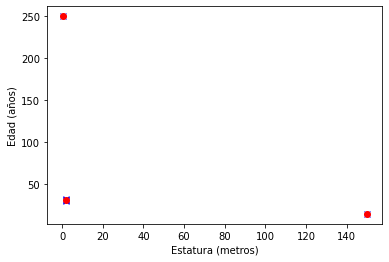

In [14]:
p_pr = multivariateGaussian(pruebas_n, mu, sigma)
outliers = np.asarray(np.where(p_pr < ep))[0]
plt.figure()
plt.xlabel("Estatura (metros)")
plt.ylabel("Edad (años)")
plt.plot(pruebas.iloc[:,0], pruebas.iloc[:,1], "bx")
plt.plot(pruebas.iloc[outliers,0], pruebas.iloc[outliers,1], "ro")
plt.show()

Acercamiento

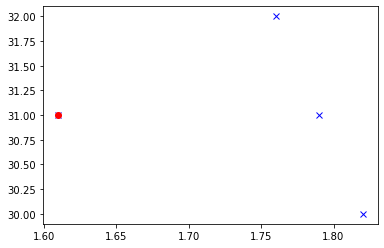

In [15]:
plt.plot(pruebas.iloc[0:4,0], pruebas.iloc[0:4,1], "bx")
plt.plot(pruebas.iloc[outliers[outliers<4],0], pruebas.iloc[outliers[outliers<4],1], "ro")
plt.show()

Tabla

In [16]:
tabla_final = pruebas.copy()
tabla_final["real"] = np.arange(start=0, stop=len(pruebas)) < int(np.floor(len(valtest_normales_n)/2))
tabla_final["prediccion"] = False
tabla_final.iloc[outliers,3] = True
tabla_final

,altura,edad,real,prediccion
4,1.82,30.0,True,False
5,1.76,32.0,True,False
6,1.79,31.0,True,False
7,1.61,31.0,True,True
2,0.15,250.0,False,True
3,150.00,14.0,False,True


# 8. Estadísticos utilizados:

In [17]:
print("media", mu[0])
print("covarianza\r\n")
print(sigma)
print("")
print("fscore", fscore)
print("probabilidad", ep)

media -1.3932210505100003e-15
covarianza

[[1.         0.10361644]
 [0.10361644 1.        ]]

fscore 0.6666666666666665
probabilidad 0.04994164309954363
